In [1]:
from lanlab import Text,Batch,Sequential,Sequence
from lanlab import load,save
from lanlab import set_number_workers

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

set_number_workers(16) #Set the number of workers to 16 to generate the data faster

genome_name = 'llemaf_nostop' #Math set of genes : llemaf_nostop // Code set of genes : codef_nostop
format = 'completion' #Which models to include : completion / chat / all

/home/nyax/git/PhyloLM/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
d=load(os.path.join('data','kl_pop','codef','probes_batch','AD','0'))

### Loading genome and alleles

In [3]:
#Load the genes
def load_genome(genome_name,G=128):
    genes_batch = Batch((G,))
    for i in range(G):
        genes_batch[i] = load(os.path.join('data','kl_pop',genome_name,'genes',str(i)))
    return genes_batch

In [4]:
#For each model in models generate nb_probes completions of 1 token to each prefix
def compute_P(models,genome,save_name,N=32):
    #Start from an empty batch
    P = [[{} for _ in range(len(models))] for _ in range(len(genome))]
    for j,m in enumerate(models):
        for k in range(N):
            print('Computing probe '+str(k)+' for model '+m.name)
            generate_pipeline = Sequential(m.configure(max_tokens=5))#,logit_bias={'50256':-100}))
            #Generate the prefix
            loaded_batch = generate_pipeline(genome,os.path.join('data','kl_pop',save_name,'probes_batch',m.name,str(k)))
            probes = np.zeros((len(genome),),dtype=object)
            for idx in range(len(genome)):
                probes[idx] = loaded_batch[idx][-1]['text'] #Get the completion (that should be the last segment in the sequence)
                probes[idx] = probes[idx].lstrip(' ').lstrip('\n')[:4] #Get the first 4 characters of the completion
                P[idx][j][probes[idx]] = P[idx][j].get(probes[idx],0)+1 #Set it as allele in matrix P(gene,model,allele)
    #Normalize the multiplicity of each probe to get probabilities
    for i in range(len(genome)):
        for j in range(len(models)):
            for k in P[i][j]:
                P[i][j][k] /= N
    return P

def match(d,k):
    if k in d:
        return d[k]
    else:
        return 0

def compute_nei_similarity(P,model_indexs,model_indexs2=None):
    #Compute similarity matrix S
    if model_indexs2 is None:
        model_indexs2 = model_indexs
    nei_sim = np.zeros((len(model_indexs),len(model_indexs2)))
    #Iterate over all pairs of models to compute each similarity
    for i in range(len(model_indexs)):
        index_i = model_indexs[i]
        for j in range(len(model_indexs2)):
            #compute the different parts of the nei formula
            up = 0
            dleft = 0
            dright = 0
            index_j = model_indexs2[j]
            for k in range(len(P)):
                for l in {**P[k][index_i],**P[k][index_j]}:
                    up += match(P[k][index_i],l)*match(P[k][index_j],l)
                for l in P[k][index_i]:
                    dleft += P[k][index_i][l]**2
                for l in P[k][index_j]:
                    dright += P[k][index_j][l]**2
            nei_sim[i,j] = up/(dleft*dright)**0.5
    return nei_sim


In [5]:
from lanlab.core.module.models import *

#All the models included in the study :
models = []
if format=='completion' or format=='all':
  models += [

          Llama7B(),'llama 1-7',
          Alpaca7B(),'llama 1-7',
          Wizard7B(),'llama 1-7',
          Vicuna7B_11(),'llama 1-7',
          Vicuna7B_13(),'llama 1-7',
          Baize7B(),'llama 1-7',
          ChimeraInstChat7B(),'llama 1-7',

          Llama13B(),'llama 1-13',
          Vicuna13B_11(),'llama 1-13',
          Vicuna13B_13(),'llama 1-13',
          OpenChat2(),'llama 1-13',
          OpenChat2W(),'llama 1-13',
          ChimeraInstChat13B(),'llama 1-13',

          Llama2HF_7B(),'llama 2-7',
          Orca2_7B(),'llama 2-7',
          TigerBotBase_7B(),'llama 2-7',
          TigerBotChat_7B(),'llama 2-7',
          OpenHermes7B(),'llama 2-7',
          Vicuna7B_15(),'llama 2-7',

          Llama2HF_13B(),'llama 2-13',
          OpenChat31(),'llama 2-13',
          OpenChat32(),'llama 2-13',
          OpenHermes13B(),'llama 2-13',
          Vicuna13B_15(),'llama 2-13',
          OpenChat32Super(),'llama 2-13',
          TigerBotBasev1_13B(),'llama 2-13',
          TigerBotBasev2_13B(),'llama 2-13',
          TigerBotChatv1_13B(),'llama 2-13',
          TigerBotChatv2_13B(),'llama 2-13',
          TigerBotChatv3_13B(),'llama 2-13',
          TigerBotChatv4_13B(),'llama 2-13',

          Bloom3B(),'bloom',
          Bloom7B(),'bloom',
          BloomZ3B(),'bloom',
          BloomZ7B(),'bloom',
          TigerBotBasev1_7B(),'bloom',
          TigerBotBasev2_7B(), 'bloom',
          TigerBotSFTv1_7B(),'bloom',
          TigerBotSFTv2_7B(),'bloom',
          PhoenixInstChat7B(),'bloom',
          Bloom176B(),'bloom',

          Pythia70M(),'pythia',
          Pythia160M(),'pythia',
          Pythia410M(),'pythia',
          Pythia1B(),'pythia',
          Pythia3B(),'pythia',
          Pythia7B(),'pythia',
          Pythia12B(),'pythia',
          Dolly3B(),'pythia',
          Dolly7B(),'pythia',
          Dolly12B(),'pythia',
          OasstSft4Pythia12bEpoch35(),'pythia',

          OPT125M(),'opt',
          OPT350M(),'opt',
          OPT1B(),'opt',
          OPT3B(),'opt',
          OPT7B(),'opt',
          OPT13B(),'opt',
          OPT30B(),'opt',
          OPT66B(),'opt',

          FalconRW1B(),'falcon',
          FalconRW7B(),'falcon',
          Falcon7B(),'falcon',
          Falcon7BI(),'falcon',
          Falcon40B(),'falcon',
            Falcon40BI(),'falcon',
            Falcon180B(),'falcon',

          Mistral7B(),'mistral',
          Mistral7BI(),'mistral',
          Mistral7BInstructV02(),'mistral',
          Zephyr7BA(),'mistral',
          Zephyr7BB(),'mistral',
          Docsgpt7BMistral(),'mistral',
          OpenChat35(),'mistral',
          TenyxChat7B(),'mistral',
          MedChat35(),'mistral',
          NeuralChat3_7B(),'mistral',
          NeuralChat31_7B(),'mistral',
          OpenHermes2_7B(),'mistral',
          OpenHermes25_7B(),'mistral',
          HarmoniousAnthea(),'mistral',
          NeuralHermes25Mistral7B(),'mistral',
          Mixtral8x7BV01(),'mistral',
          Mixtral8x7BInstructV01(),'mistral',
          
          

          QWEN2B(),'qwen',
          QWEN7B(),'qwen',
          QWEN14B(),'qwen',
          QWEN72B(),'qwen',
          CausalLM7B(),'qwen',
          CausalLM14B(),'qwen',

          QWEN15_500M(),'qwen',
          QWEN15_2B(),'qwen',
          QWEN15_4B(),'qwen',
          QWEN15_7B(),'qwen',
          QWEN15_14B(),'qwen',
          QWEN15_32B(),'qwen',
          QWEN15_72B(),'qwen',

          QWEN15Ch_500M(),'qwen',
          QWEN15Ch_2B(),'qwen',
          QWEN15Ch_4B(),'qwen',
          QWEN15Ch_7B(),'qwen',
          QWEN15Ch_14B(),'qwen',
          QWEN15Ch_32B(),'qwen',
          QWEN15Ch_72B(),'qwen',

          

            Gemma2B(),'gemma',
            Gemma2BI(),'gemma',
          Gemma7B(),'gemma',
        Gemma7BI(),'gemma',
        Gemma1p1_2BI(),'gemma',
        Gemma1p1_7BI(),'gemma',
        CodeGemma2B(),'gemma',
        CodeGemma7B(),'gemma',
        CodeGemma7BI(),'gemma',

        AD(),'gpt 3',
          BB(),'gpt 3',
          CU(),'gpt 3',
          DV(),'gpt 3',
          DVB(),'gpt 3',
          TAD1(),'gpt 3',
          TBB1(),'gpt 3',
          TCU1(),'gpt 3',
          TDV1(),'gpt 3',
          
          TDV2(),'gpt 3.5',
          TDV3(),'gpt 3.5',
          BB2(),'gpt 3.5',
          DV2(),'gpt 3.5',
          GPT35I_0914(),'gpt 3.5',]
  nb_completion_models = len(models)//2
if format == 'chat' or format == 'all':
  models += [
          GPT35_0301(),'gpt 3.5',
          GPT35_0613(),'gpt 3.5',
          GPT35_1106(),'gpt 3.5',
          GPT4_0314(),'gpt 4',
          GPT4_0613(),'gpt 4',
          GPT4V(),'gpt 4',
          GPT4_1106(),'gpt 4',
          GPT4_0125(),'gpt 4',

          ClaudeInstant12(),'claude',
          Claude2(),'claude',
          Claude21(),'claude',
          Claude3Haiku(),'claude',
          Claude3Sonnet(),'claude',
          Claude3Opus(),'claude',

          MistralTiny2312(), 'mistral',
          MistralSmall2312(), 'mistral',
          MistralSmall2402(), 'mistral',
          MistralMedium2312(), 'mistral',
          MistralLarge2402(), 'mistral',

          TextBison1(), 'palm',
          TextBison2(), 'palm',
          TextUnicorn1(), 'palm',
          ChatBison1(), 'palm',
          ChatBison2(), 'palm',
          CodeBison1(), 'palm',
          CodeBison2(), 'palm',
          #CodeChatBison1(), 'google', #Not available
          #CodeChatBison2(), 'google', #Not available
          Gemini1(), 'gemini',
          Gemini1_001(), 'gemini',
          Gemini1_002(), 'gemini',
          Gemini1V(), 'gemini',
          Gemini1V_001(), 'gemini',
          #Gemini1p5_0409(), 'gemini' #Too slow
]

origins = models[1::2]
models = models[::2]
model_names = [m.name for m in models]
labels = [{'name':m.name,'origin':o, 'engine':m.engine} for m,o in zip(models,origins)]

import logging
logging.basicConfig(level=logging.INFO)

#Generate text
genome = load_genome(genome_name,128)


In [6]:
#Compute Nei similarity
P = compute_P(models,genome,genome_name,N=32)
nei_sim = compute_nei_similarity(P,range(len(models)))

Computing probe 0 for model LLA7
Computing probe 1 for model LLA7
Computing probe 2 for model LLA7
Computing probe 3 for model LLA7
Computing probe 4 for model LLA7
Computing probe 5 for model LLA7
Computing probe 6 for model LLA7
Computing probe 7 for model LLA7
Computing probe 8 for model LLA7
Computing probe 9 for model LLA7
Computing probe 10 for model LLA7
Computing probe 11 for model LLA7
Computing probe 12 for model LLA7
Computing probe 13 for model LLA7
Computing probe 14 for model LLA7
Computing probe 15 for model LLA7
Computing probe 16 for model LLA7
Computing probe 17 for model LLA7
Computing probe 18 for model LLA7
Computing probe 19 for model LLA7
Computing probe 20 for model LLA7
Computing probe 21 for model LLA7
Computing probe 22 for model LLA7
Computing probe 23 for model LLA7
Computing probe 24 for model LLA7
Computing probe 25 for model LLA7
Computing probe 26 for model LLA7
Computing probe 27 for model LLA7
Computing probe 28 for model LLA7
Computing probe 29 for m

### Set colors

In [7]:
#general families colors
colors = {'claude':'#bb9457',
          'palm':'#99582a',
          'gemini':'#8f1515',
            'llama':'#3185fc',
          'opt':'#d62828',
          'pythia':'#ff595e',
          'bloom':'#ff924c',
          
          'qwen':'#ffca3a',
          'falcon':'#c5ca30',
          'mistral':'#8ac926',
          
          'gpt':'#f58606',
          
          'gemma':'#36949d',
          }
#Colors for the subfamilies of llama
colors_llama = {'1-7':'#1982c4',
                '1-13':'#4267ac',
                '2-7':'#565aa0',
                '2-13':'#6a4c93'}

colors_gpt = {
    '3':'#4d5162',
    '3.5':'#6f7d95',
    '4':'#bfc0c0',
              }

#Useful functions
matplotlib.colors.to_rgb = matplotlib.colors.ColorConverter().to_rgb
matplotlib.colors.to_rgba = matplotlib.colors.ColorConverter().to_rgba
matplotlib.colors.to_rgba_array = matplotlib.colors.ColorConverter().to_rgba_array

#Transform to RGB tuples for the Bio.Phylo package to plot dendrograms
#colors_ = {k:matplotlib.colors.to_rgb(colors[k]) for k in colors}
colors_ = {k:matplotlib.colors.to_rgb(v) for k,v in colors.items()}
colors_ = {k:((int(v[0]*255),int(v[1]*255),int(v[2]*255))) for k,v in colors_.items()}

#colors_llama_ = {k:matplotlib.colors.to_rgb(colors_llama[k]) for k in colors_llama}
colors_llama_ = {k:matplotlib.colors.to_rgb(v) for k,v in colors_llama.items()}
colors_llama_ = {k:((int(v[0]*255),int(v[1]*255),int(v[2]*255))) for k,v in colors_llama_.items()}

### Plot similarity matrix

In [8]:
def plot_matrix(data,labels,labels2=None,vmin=0,vmax=1,mode='names',fontsize=15): #modes are 'names' or 'colors'
    #Unpack inputs
    if labels2 is None:
        labels2 = labels
    origins = [l['origin'] for l in labels]
    origins2 = [l['origin'] for l in labels2]
    labels_color = [colors[l.split(' ')[0].lower()] for l in origins]
    labels2_color = [colors[l.split(' ')[0].lower()] for l in origins2]

    #If mode is names, we will plot with the names of the models on the side
    if mode == 'names':
        colored_plot = False
        no_indexs = False
        names = [l['engine'] for l in labels]
        names2 = [l['engine'] for l in labels2]
    #If mode is colors, we will plot with the colors instead of the names on the sides
    if mode == 'colors':
        colored_plot = True
        no_indexs = True

    #Prepare the figure
    fig, ax = plt.subplots(figsize=(35,35))
    cm = plt.get_cmap('gray')
    #cm = plt.cm.get_cmap('gray')
    cm.set_bad('Black')
    
    #plot with the colors
    if colored_plot:
        #Offset for position of color boxes to align with imshow
        offset = 0.50
        lw = 2
        if no_indexs:
            offset -= 1
        #Find separation between different families
        indexs = []
        prev = None
        for i,l in enumerate(labels_color):
            if prev is None or prev != l:
                indexs.append(i)
                prev = l
        indexs.append(len(labels_color))
        #Plot the family color squares in the plot
        for i in range(len(indexs)-1):
            #plot square from index[i],index[i] to index[i+1],index[i+1]
            ax.plot([indexs[i]-offset,indexs[i]-offset],[indexs[i]-offset,indexs[i+1]-offset],color=labels_color[indexs[i]],linewidth=lw)
            ax.plot([indexs[i]-offset,indexs[i+1]-offset],[indexs[i+1]-offset,indexs[i+1]-offset],color=labels_color[indexs[i]],linewidth=lw)
            ax.plot([indexs[i+1]-offset,indexs[i+1]-offset],[indexs[i]-offset,indexs[i+1]-offset],color=labels_color[indexs[i]],linewidth=lw)
            ax.plot([indexs[i]-offset,indexs[i+1]-offset],[indexs[i]-offset,indexs[i]-offset],color=labels_color[indexs[i]],linewidth=lw)

        #If the size of the square is larger than 4x4, write the name of the model in the middle
        model_names = [l.split(' ')[0] for i,l in enumerate(origins) if i in indexs]
        for i in range(len(indexs)-1):
            if indexs[i+1]-indexs[i] >= 4:
                #fontsize depends on the size of the square
                fontsize = ((indexs[i+1]-indexs[i]))**0.4*18 #hand cooked formula
                
                ax.text((indexs[i]+indexs[i+1])/2-offset,(indexs[i]+indexs[i+1])/2-offset,model_names[i],color=labels_color[indexs[i]],fontsize=fontsize,ha='center',va='center',weight='bold',path_effects=[pe.withStroke(linewidth=10, foreground="black")],alpha=1)

    #Plot color boxes on the sides instead of model names
    if no_indexs:
        colored_data = np.zeros((len(labels)+1,len(labels)+1,4))
        #first row and columns are colors of labels
        colored_data[1:,0] = [matplotlib.colors.to_rgba(c) for c in labels_color]
        colored_data[0,1:] = [matplotlib.colors.to_rgba(c) for c in labels_color]
        colored_data[0,0] = [0,0,0,1]
        for i in range(len(labels)):
            for j in range(len(labels2)):
                colored_data[i+1,j+1] = [data[i,j],data[i,j],data[i,j],1]
    else:
        colored_data = data

    #Plot similarity matrix
    im = ax.imshow(colored_data,cmap=cm,vmin=vmin,vmax=vmax,aspect='equal',interpolation='nearest')

    #Plot names on the sides
    if not no_indexs:
        #Put names as axis labels
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels2))[::-1])
        ax.set_xticklabels(names,fontsize=fontsize, fontweight='bold')
        ax.set_yticklabels(reversed(names2),fontsize=fontsize, fontweight='bold')
        #Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

        if labels_color is not None:
            for i in range(len(labels_color)):
                plt.gca().get_xticklabels()[i].set_color(labels_color[i])
            for j in range(len(labels2_color)):
                plt.gca().get_yticklabels()[len(labels2_color)-j-1].set_color(labels2_color[j])
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    return fig,ax

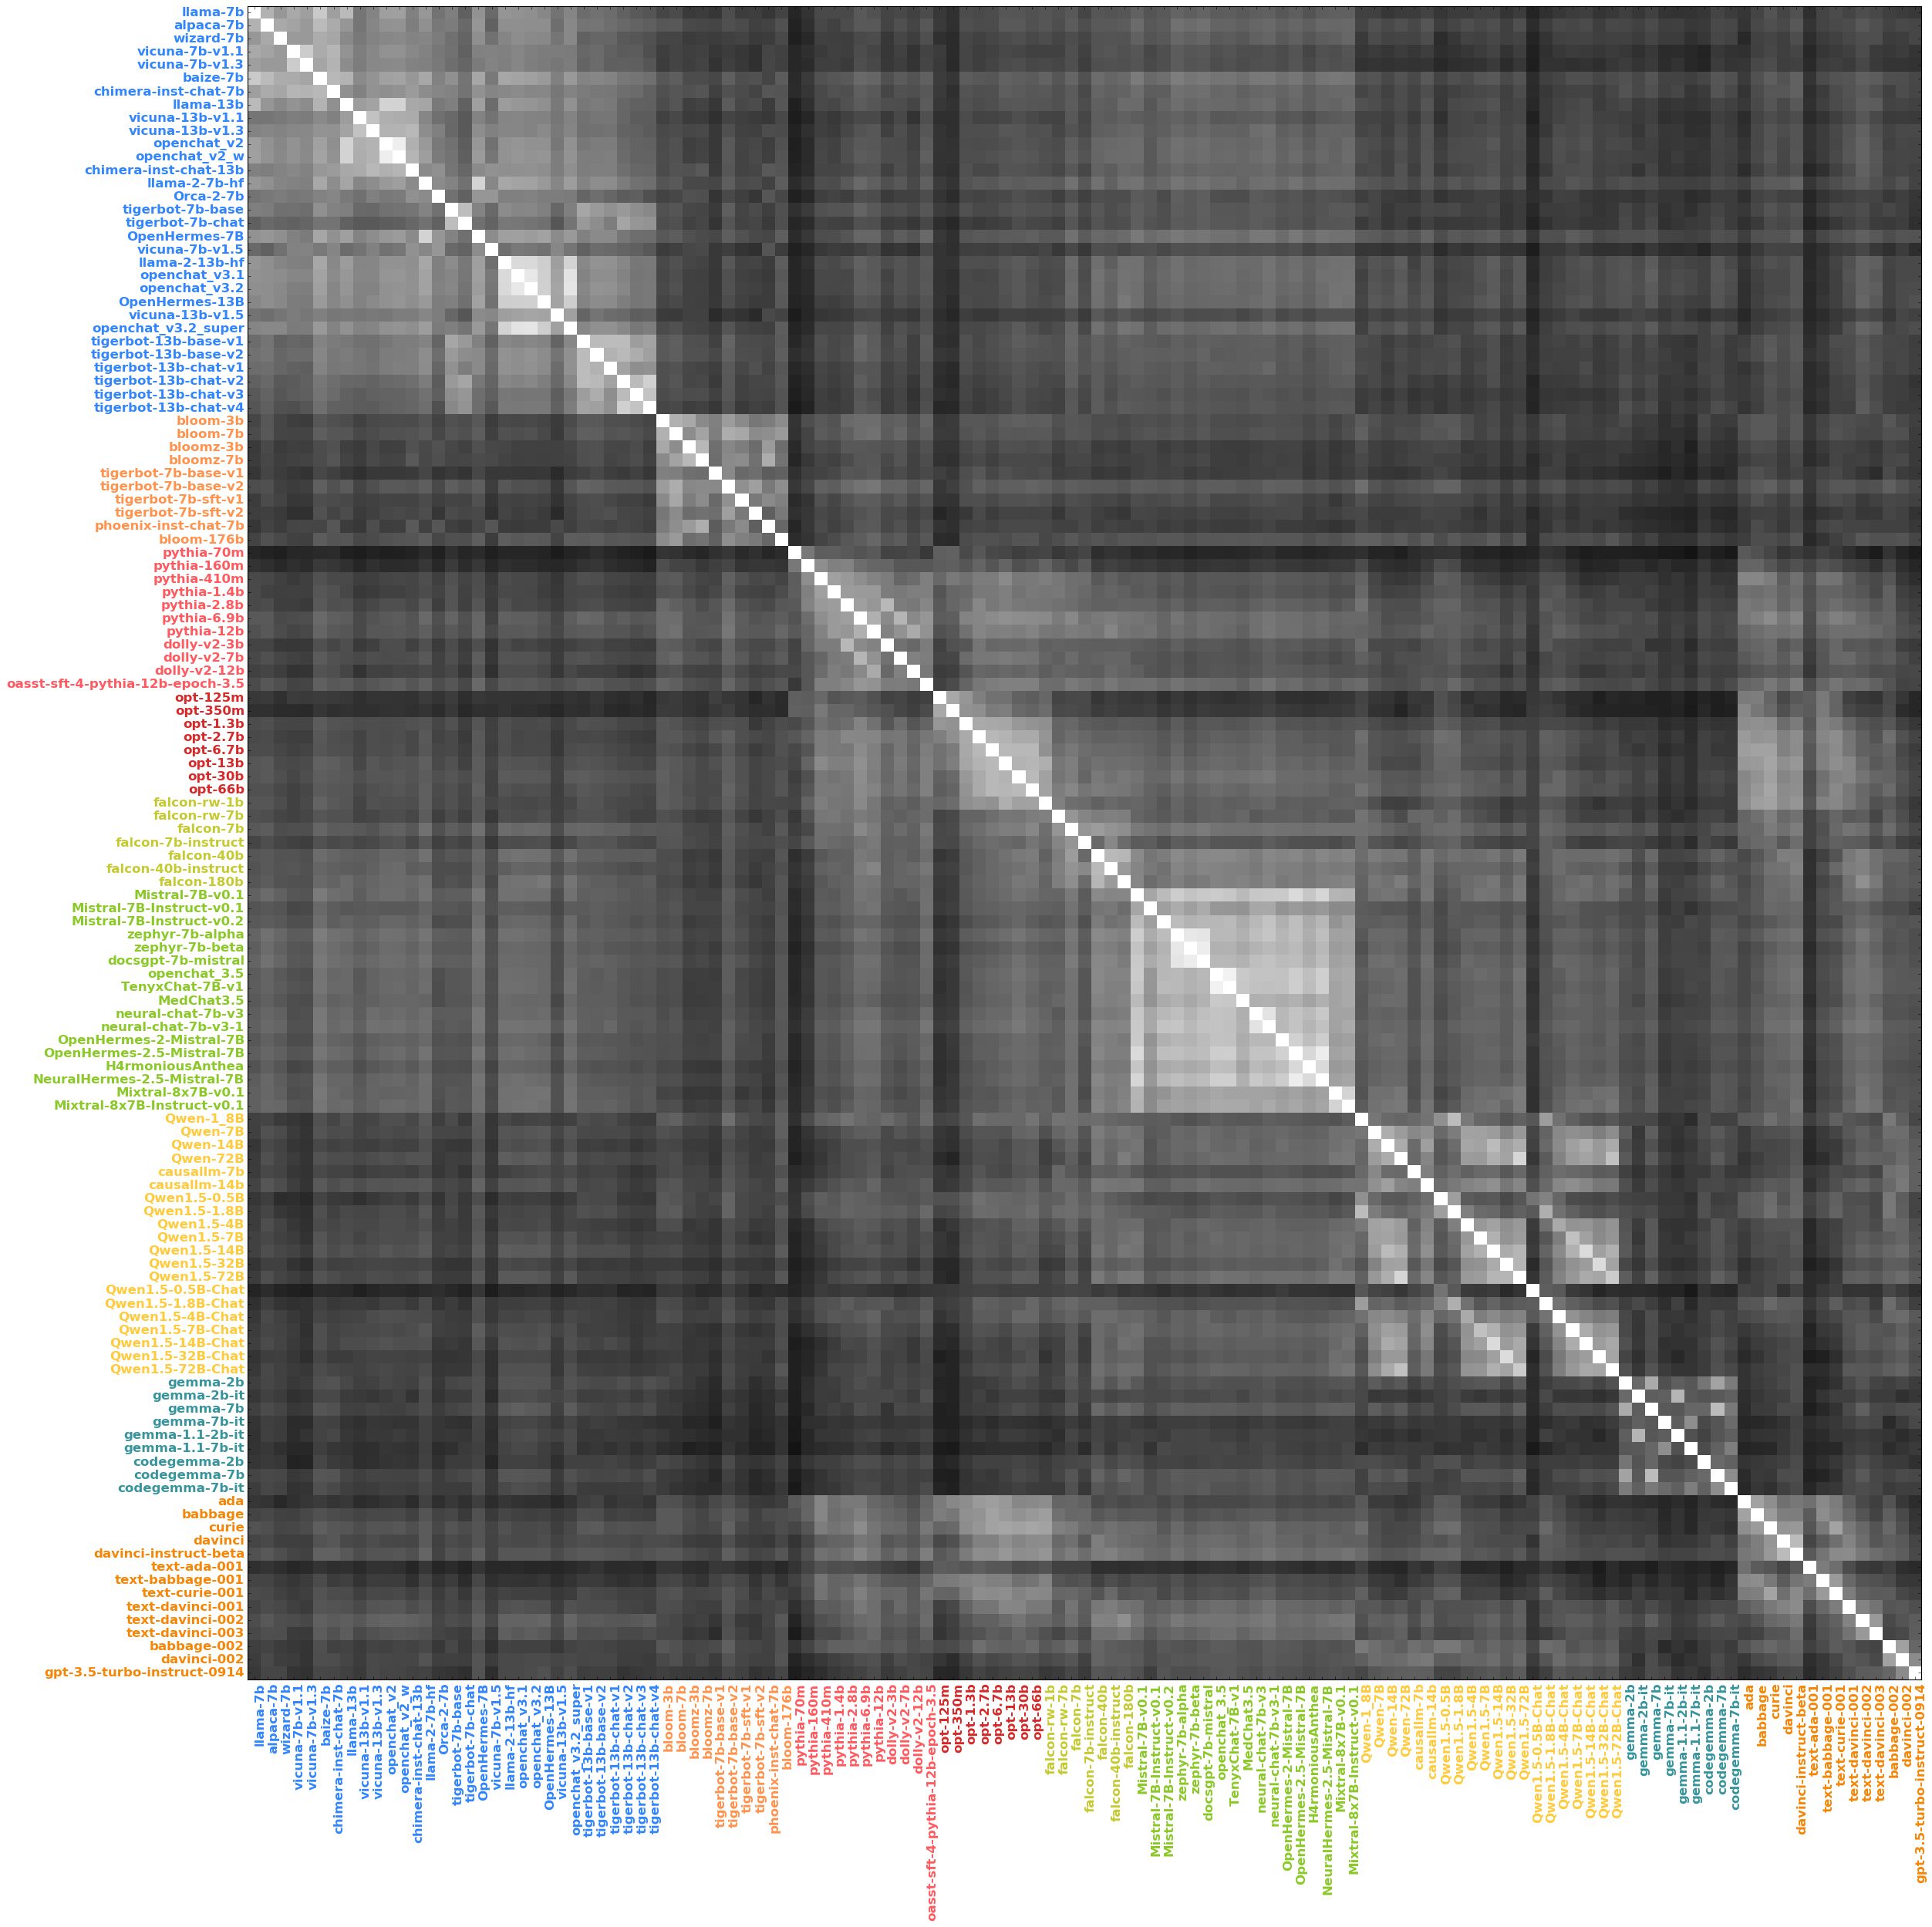

In [9]:
mode = 'names'
fontsize = 15
if format == 'all':
    mode = 'colors'
if format == 'chat':
    fontsize = 30
fig,ax  = plot_matrix(nei_sim,labels,mode=mode,fontsize=fontsize)
fig.patch.set_facecolor('white')

if format=='all':
    #add line between completion and chat models
    print(len(labels),nb_completion_models)
    offset=0.5
    ax.plot([0-offset,len(labels)-offset],[nb_completion_models-offset,nb_completion_models-offset],color='purple',linewidth=4)
    ax.plot([nb_completion_models-offset,nb_completion_models-offset],[0-offset,len(labels)-offset],color='purple',linewidth=4)

if format == 'chat':
    plt.tight_layout()

#Save svg in similarity_matrix_llemaf_nostop format
plt.savefig('similarity_matrix_'+format+'_'+genome_name+'.svg',format='svg')

### Dendrograms

In [10]:
def prepare_tree(tree,model_names,origins):
    #Put colors on the trees
    global colors_,colors_llama_
    #Remove inner node names as they refer to common ancestors
    for clade in tree.find_clades():
        if clade.name and clade.name.startswith('Inner'):
            clade.name = None
        if clade.name is None:
            continue
        #Color the clades if it is a leaf
        index = model_names.index(clade.name)
        clade_family = origins[index]
        clade.color = colors_[clade_family.split(' ')[0]]
        if clade_family.split(' ')[0] == 'llama':
            clade.color = colors_llama_[clade_family.split(' ')[1]]
        if clade_family.split(' ')[0] == 'gpt':
            clade.color = colors_gpt[clade_family.split(' ')[1]]
    for clade in tree.find_clades():
      if clade.name and clade.name.startswith('Inner'):
        clade.name = None
    #If clade has all its children with the same color, make the clade to this color
    all_clades = tree.find_clades() #Store all clades in a list
    clades = []
    for clade in all_clades:
        clade.locked = False
        if clade.color is None:
            clades.append(clade)
    #Iterate this process until there are no more clades to color
    i = 0
    while len(clades) > 0:
        clade = clades[i%len(clades)]
        children_colors = [(c.color.red,c.color.green,c.color.blue) for c in clade.clades if not(c.color is None)]
        locked = any([c.locked for c in clade.clades])
        if len(set(children_colors)) == 1 and len(children_colors) == len(clade.clades):
            clade.color = children_colors[0]
            del clades[i%len(clades)]
        elif len(set(children_colors))>1:
            clade.locked = True
            del clades[i%len(clades)]
        elif locked:
            clade.locked = True
            del clades[i%len(clades)]
        i += 1

In [11]:
kept_models = [m for m in models if m.name in model_names]

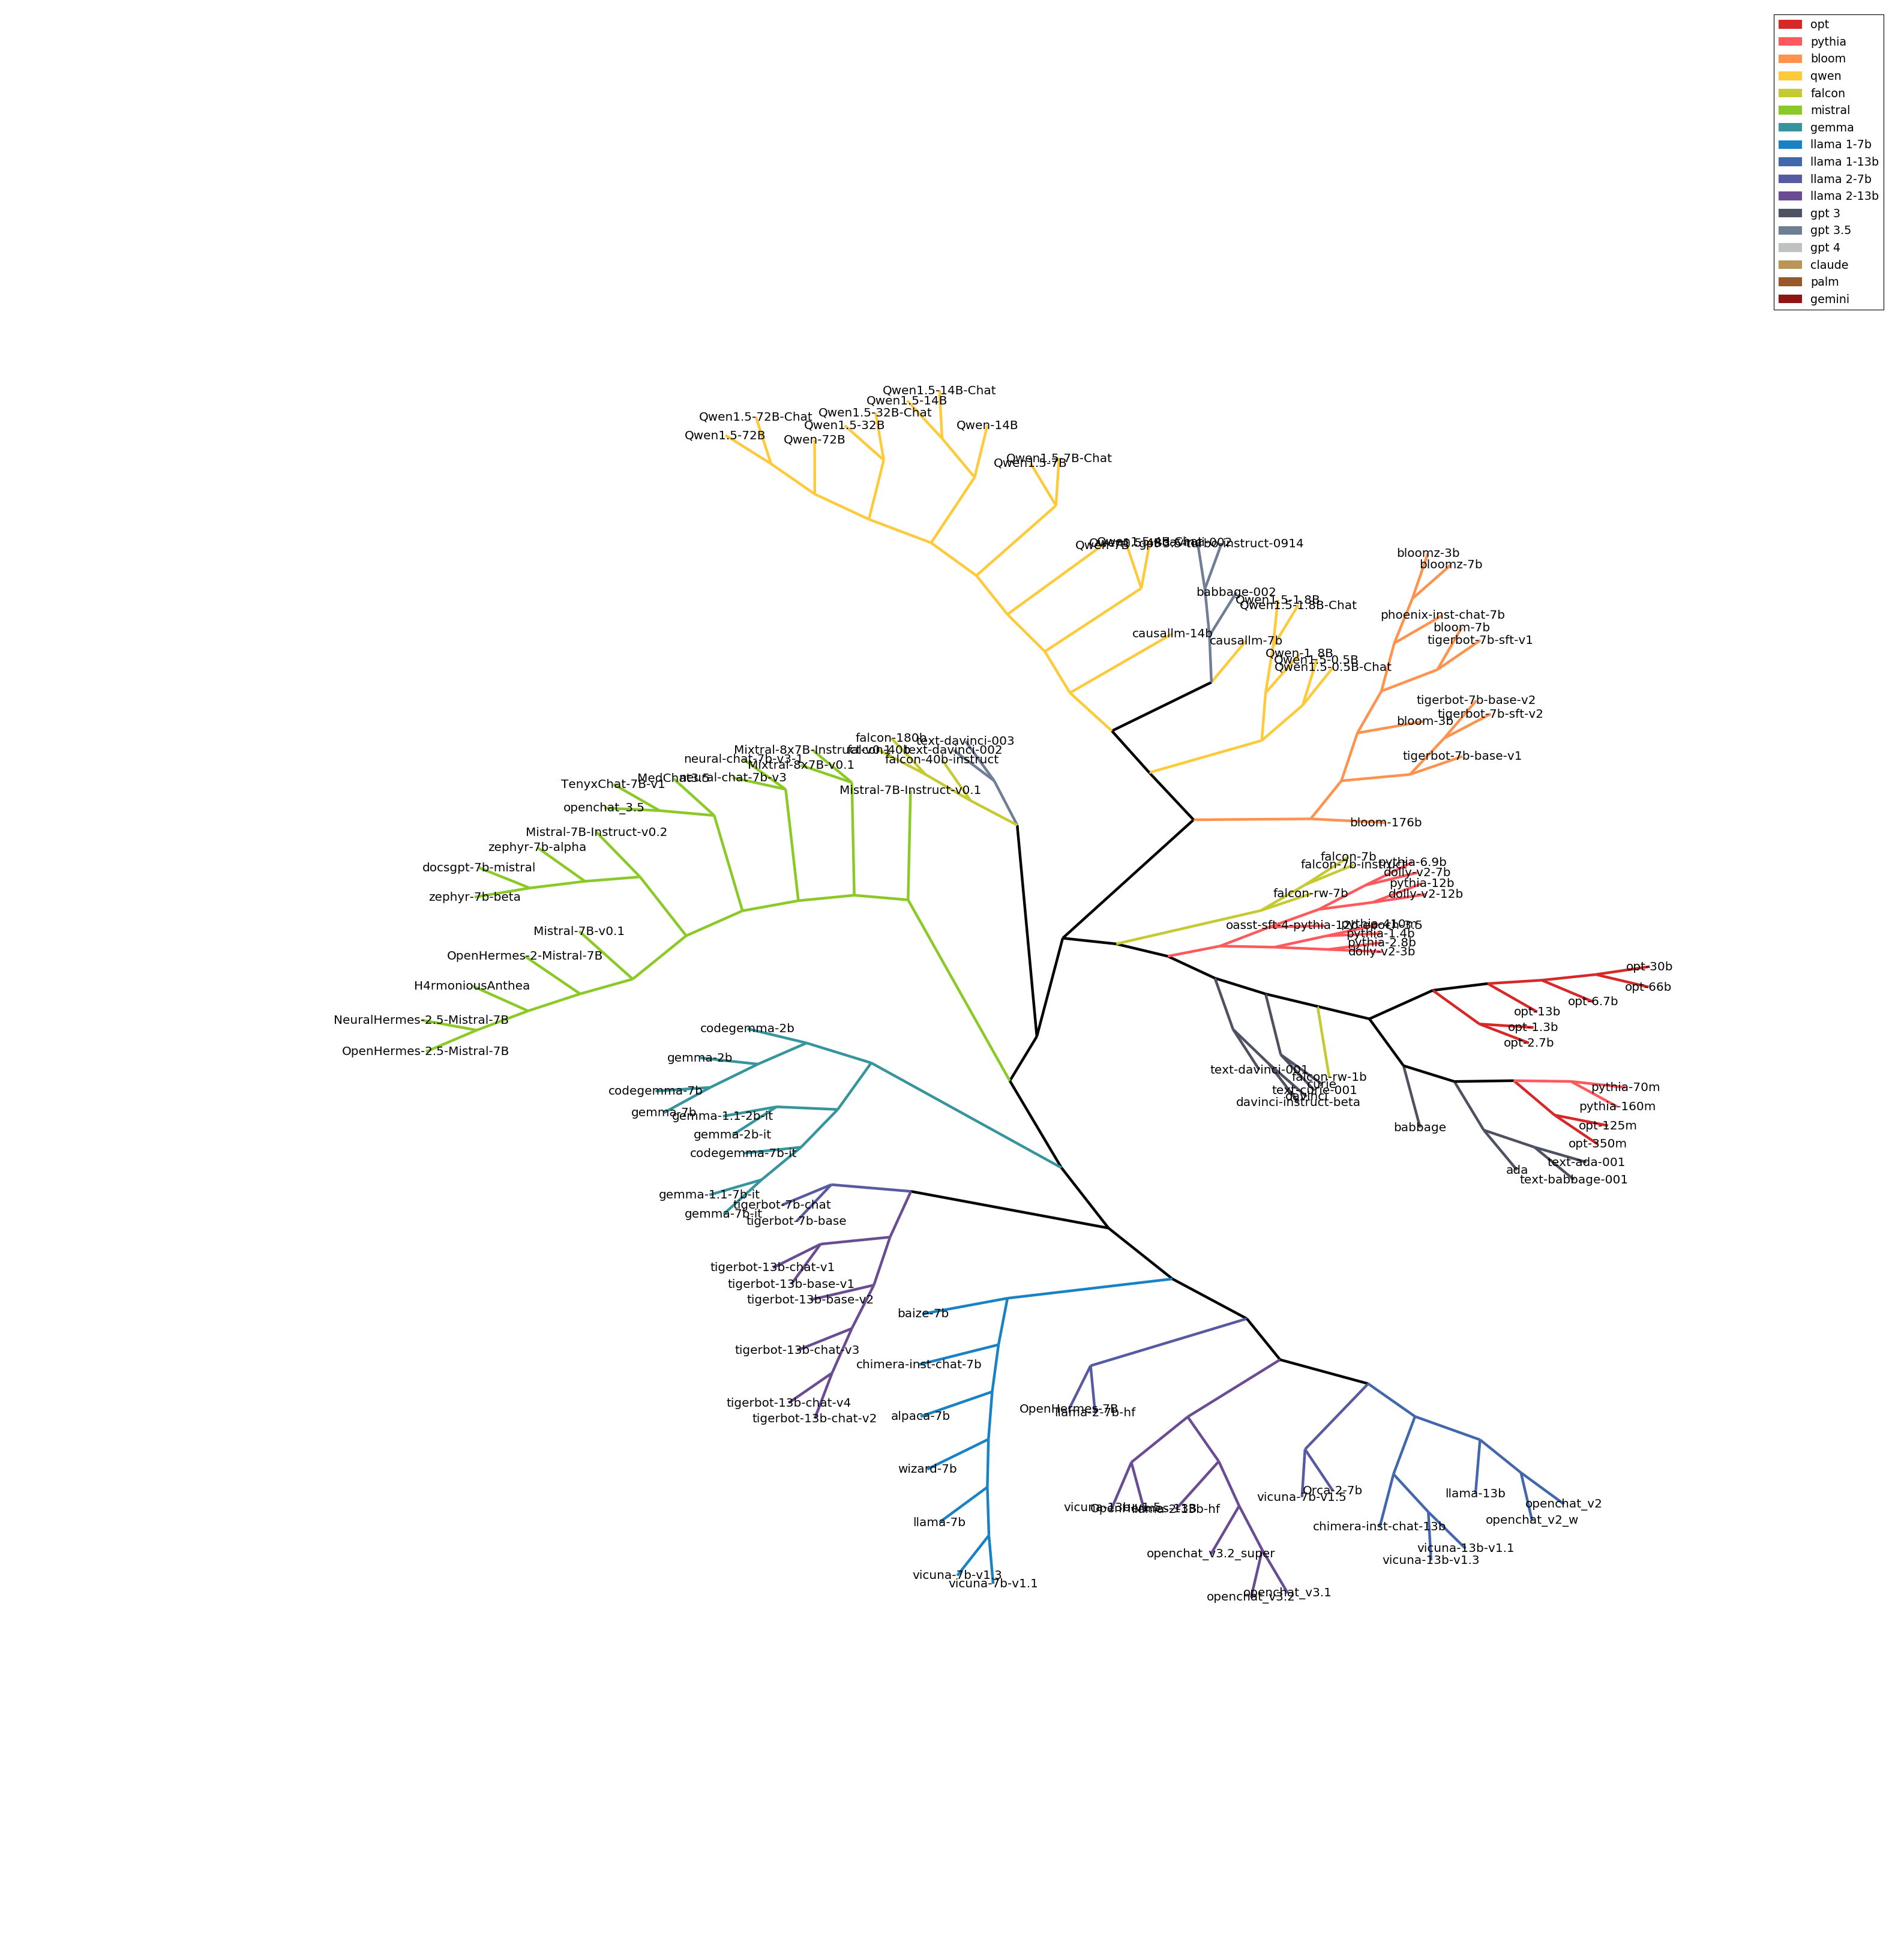

In [27]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator, _DistanceMatrix

#Setup Bio.Phylo
calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')

#Prepare the models to include in the tree
model_names = [m.engine for m in models]
kept_models = model_names.copy()
indexs = [model_names.index(kept_models[i]) for i in range(len(kept_models))]

#Prepare the distance matrix
dist_matrix = -np.log(np.maximum(nei_sim ,1e-10)) #Careful of log(0)
kept_dist_matrix = dist_matrix[indexs][:,indexs]

#Prepare the data for Bio.Phylo
low_triangle_kl_mean = [[kept_dist_matrix[i][j] for j in range(i+1)] for i in range(len(kept_dist_matrix))]
df = _DistanceMatrix(names=[m for m in kept_models],matrix=low_triangle_kl_mean)

#build the tree
NJTree = constructor.nj(df)
NJTree.ladderize(reverse=False)

#Color the tree
prepare_tree(NJTree,model_names,origins)

#Remove names from the tree
for clade in NJTree.find_clades():
    pass
    #clade.name = None #comment/uncomment to remove names from the tree

#Prepare figure
fig = plt.figure(figsize=(50,50))
axes = plt.gca()

#Plot the unrooted tree
from Bio import MissingPythonDependencyError
try:
    Phylo.draw_graphviz(NJTree,axes=axes,do_show=False,node_size=0,font_size=18)
except: #Pygraphviz not installed
    Phylo.draw(NJTree,axes=axes,do_show=False,branch_labels=lambda c:None)

#plot legend with patches
patches = []
import matplotlib.patches as mpatches

#Open access families colors
for family in colors:
    if family not in ['gpt','claude','palm','gemini','llama']:#family in origins:
        color_patch = mpatches.Patch(color=colors[family],label=family)
        patches.append(color_patch)

#Llama colors
for family in colors_llama:
    color_patch = mpatches.Patch(color=colors_llama[family],label='llama '+family+'b')
    patches.append(color_patch)

#GPT colors
for family in colors_gpt:
    color_patch = mpatches.Patch(color=colors_gpt[family],label='gpt '+family)
    patches.append(color_patch)

#Other families
for family in ['claude','palm','gemini']:
    color_patch = mpatches.Patch(color=colors[family],label=family)
    patches.append(color_patch)

#Plot the legend
leg = plt.legend(handles=patches,loc='upper right',fontsize='x-large')

#Make the legend bigger
for text in leg.get_texts():
    text.set_fontsize('x-large')

#make lines in the figure bigger
for ch in axes.get_children():
    if isinstance(ch,matplotlib.collections.LineCollection):
        ch.set_linewidth(4)
        
#Show and save svg
plt.savefig('dendrogram_'+str(format)+'_'+str(genome_name)+'.svg')
plt.show()

### Quantization analysis

In [13]:
#list of models and their 4b,8b and AQW versions for 500M 2B 4B 7B 14B 72B
models_qwen = [
    QWEN15Ch_500M(),'qwen',
    QWEN15Ch8b_500M(),'qwen',
    QWEN15Ch4b_500M(),'qwen',
    QWEN15ChAWQ_500M(),'qwen',

    QWEN15Ch_2B(),'qwen',
    QWEN15Ch8b_2B(),'qwen',
    QWEN15Ch4b_2B(),'qwen',
    QWEN15ChAWQ_2B(),'qwen',

    QWEN15Ch_4B(),'qwen',
    QWEN15Ch8b_4B(),'qwen',
    QWEN15Ch4b_4B(),'qwen',
    QWEN15ChAWQ_4B(),'qwen',

    QWEN15Ch_7B(),'qwen',
    QWEN15Ch8b_7B(),'qwen',
    QWEN15Ch4b_7B(),'qwen',
    QWEN15ChAWQ_7B(),'qwen',

    QWEN15Ch_14B(),'qwen',
    QWEN15Ch8b_14B(),'qwen',
    QWEN15Ch4b_14B(),'qwen',
    QWEN15ChAWQ_14B(),'qwen',

    #Not available yet
    #QWEN15Ch_32B(),'qwen',
    #QWEN15Ch4b_32B(),'qwen',
    #QWEN15Ch8b_32B(),'qwen',
    #QWEN15ChAWQ_32B(),'qwen',

    QWEN15Ch_72B(),'qwen',
    QWEN15Ch8b_72B(),'qwen',
    QWEN15Ch4b_72B(),'qwen',
    QWEN15ChAWQ_72B(),'qwen',
]

origins_qwen = models_qwen[1::2]
models_qwen = models_qwen[::2]
model_names_qwen = [m.name for m in models_qwen]
labels_qwen = [{'name':m.name,'origin':o, 'engine':m.engine} for m,o in zip(models_qwen,origins_qwen)]
            

In [14]:
#Compute Nei similarity
P_qwen = compute_P(models_qwen,genome,genome_name,N=32)
nei_sim_qwen = compute_nei_similarity(P_qwen,range(len(models_qwen)))

Computing probe 0 for model QWE15Ch_500m
Computing probe 1 for model QWE15Ch_500m
Computing probe 2 for model QWE15Ch_500m
Computing probe 3 for model QWE15Ch_500m
Computing probe 4 for model QWE15Ch_500m
Computing probe 5 for model QWE15Ch_500m
Computing probe 6 for model QWE15Ch_500m
Computing probe 7 for model QWE15Ch_500m
Computing probe 8 for model QWE15Ch_500m
Computing probe 9 for model QWE15Ch_500m
Computing probe 10 for model QWE15Ch_500m
Computing probe 11 for model QWE15Ch_500m
Computing probe 12 for model QWE15Ch_500m
Computing probe 13 for model QWE15Ch_500m
Computing probe 14 for model QWE15Ch_500m
Computing probe 15 for model QWE15Ch_500m
Computing probe 16 for model QWE15Ch_500m
Computing probe 17 for model QWE15Ch_500m
Computing probe 18 for model QWE15Ch_500m
Computing probe 19 for model QWE15Ch_500m
Computing probe 20 for model QWE15Ch_500m
Computing probe 21 for model QWE15Ch_500m
Computing probe 22 for model QWE15Ch_500m
Computing probe 23 for model QWE15Ch_500m
Co

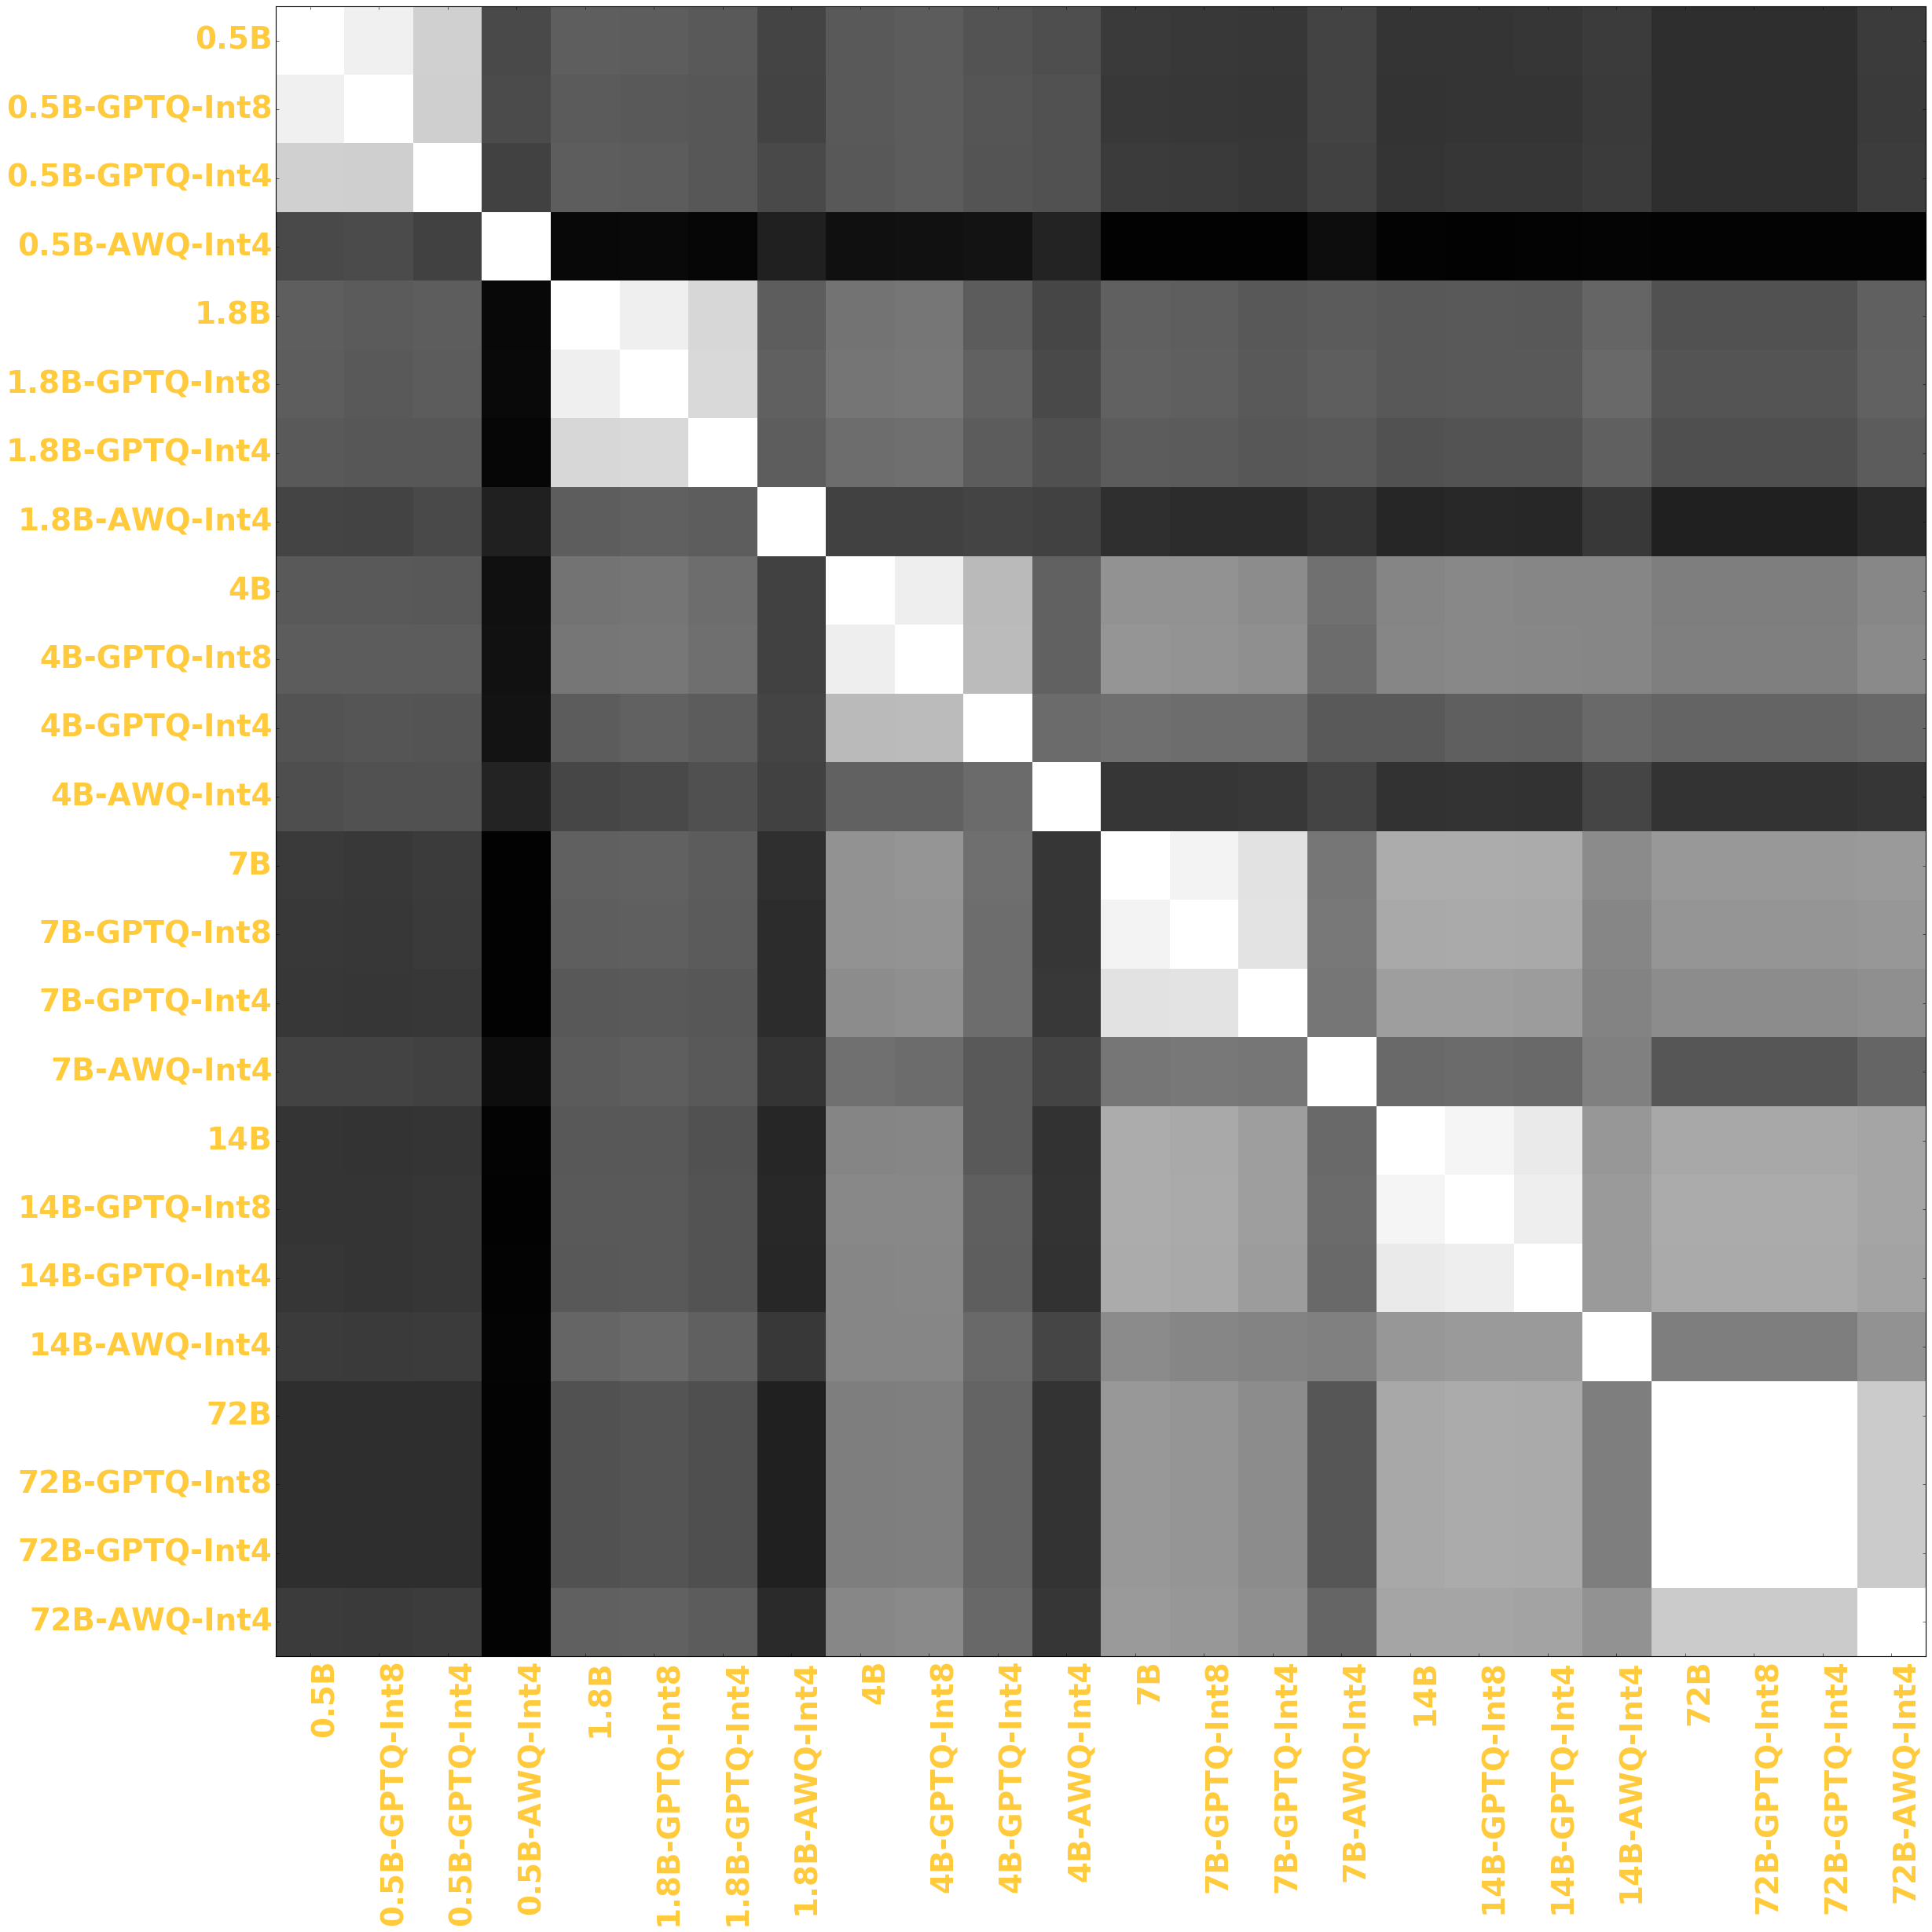

In [15]:
#simplify engines for plotting clarity
for l in labels_qwen:
    li = l['engine'].split('-')
    if len(li) == 3:
        l['engine'] = li[1]
    elif len(li) == 4:
        l['engine'] = li[1]+'-'+li[3]+'-Int4'
    else:
        l['engine'] = li[1]+'-'+li[3]+'-'+li[4]

fig,ax = plot_matrix(nei_sim_qwen,labels_qwen,mode='names',fontsize=35)
fig.patch.set_facecolor('white')
#save svg
plt.subplots_adjust(bottom=0.15,left=0.15)
#plt.savefig('quantization_'+genome_name+'.svg')

In [16]:
#Store all the data for later plotting
sizes_qwen = np.array([500,1800,4000,7000,14000,72000])*1000000 #Sizes of the models

#Compute the similarity of the 4bit, 8bit and AQW models to the original model
sim4bit = [None,None]
sim8bit = [None,None]
simawq = [None,None]

for j,genome_name_qwen in enumerate(['llemaf_nostop','codef_nostop']):
    #plot 4bit similarity to the original model
    genome_qwen = load_genome(genome_name_qwen,128)
    P_qwen = compute_P(models_qwen,genome_qwen,genome_name_qwen,N=32)
    nei_sim_qwen = compute_nei_similarity(P_qwen,range(len(models_qwen)))

    #Store the differences between the original models and their 4bit, 8bit and AQW versions
    sim4bit[j] = [nei_sim_qwen[i*4,i*4+2] for i in range(6)]
    sim8bit[j] = [nei_sim_qwen[i*4,i*4+1] for i in range(6)]
    simawq[j] = [nei_sim_qwen[i*4,i*4+3] for i in range(6)]



Computing probe 0 for model QWE15Ch_500m
Computing probe 1 for model QWE15Ch_500m
Computing probe 2 for model QWE15Ch_500m
Computing probe 3 for model QWE15Ch_500m
Computing probe 4 for model QWE15Ch_500m
Computing probe 5 for model QWE15Ch_500m
Computing probe 6 for model QWE15Ch_500m
Computing probe 7 for model QWE15Ch_500m
Computing probe 8 for model QWE15Ch_500m
Computing probe 9 for model QWE15Ch_500m
Computing probe 10 for model QWE15Ch_500m
Computing probe 11 for model QWE15Ch_500m
Computing probe 12 for model QWE15Ch_500m
Computing probe 13 for model QWE15Ch_500m
Computing probe 14 for model QWE15Ch_500m
Computing probe 15 for model QWE15Ch_500m
Computing probe 16 for model QWE15Ch_500m
Computing probe 17 for model QWE15Ch_500m
Computing probe 18 for model QWE15Ch_500m
Computing probe 19 for model QWE15Ch_500m
Computing probe 20 for model QWE15Ch_500m
Computing probe 21 for model QWE15Ch_500m
Computing probe 22 for model QWE15Ch_500m
Computing probe 23 for model QWE15Ch_500m
Co

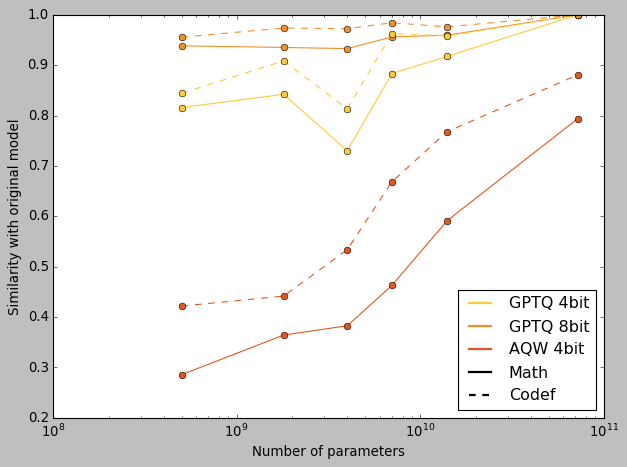

In [17]:
from scipy.stats import pearsonr
from matplotlib.lines import Line2D

fig = plt.Figure()
fig.patch.set_facecolor('white')

#Plot the similarity of the 4bit, 8bit and AQW models to the original model for both genomes
for i,genome_name_qwen in enumerate(['llemaf_nostop','codef_nostop']):
    if i==0:
        plt.plot(sizes_qwen,sim4bit[i],marker='o',color='#ffca3a',label='GPTQ 4bit')
        plt.plot(sizes_qwen,sim8bit[i],marker='o',color='#F1912E',label='GPTQ 8bit')
        plt.plot(sizes_qwen,simawq[i],marker='o',color='#E25822',label='AQW 4bit')
    else:
        plt.plot(sizes_qwen,sim4bit[i],marker='o',color='#ffca3a',linestyle='--')
        plt.plot(sizes_qwen,sim8bit[i],marker='o',color='#F1912E',linestyle='--')
        plt.plot(sizes_qwen,simawq[i],marker='o',color='#E25822',linestyle='--')

plt.xscale('log')

plt.xlabel('Number of parameters')
plt.ylabel('Similarity with original model')



#model color for legend
custom_lines = [Line2D([0], [0], color='#ffca3a', lw=2),
                Line2D([0], [0], color='#F1912E', lw=2),
                Line2D([0], [0], color='#E25822', lw=2)]

#Add legend : plain line is math and dashed line is codef
from matplotlib.lines import Line2D
custom_lines += [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', lw=2,linestyle='--')]

#Add custom line to existing legend and plot it in 2 columns with math/code on one line and model color on the second side. Put the legend on the right of the figure outside of the figure
plt.legend(custom_lines, ['GPTQ 4bit','GPTQ 8bit','AQW 4bit','Math','Codef'],ncol=1,loc='lower right')
#save svg

#include legend in savefig
plt.tight_layout()
#plt.subplots_adjust(right=0.7)

plt.savefig('quantization_sizes.svg')

In [18]:
from scipy.stats import pearsonr

#X is sizes_qwen, Y are each of the sim4bit, sim8bit and simawq for math/code (6 Y in total)
X = np.log(sizes_qwen)
Y = np.stack([sim4bit[0],sim8bit[0],simawq[0],sim4bit[1],sim8bit[1],simawq[1]])

#compute rho and p
rho = np.zeros((6,))
p = np.zeros((6,))
for i in range(6):
    rho[i],p[i] = pearsonr(X,Y[i])

print(rho)
print(p)

#Compute t-test against null hypothesis
from scipy.stats import ttest_1samp
t,p = ttest_1samp(rho,0)

print(t)
print(p)

[0.74443581 0.8746557  0.96676361 0.7668656  0.93028811 0.96275776]
[0.08962374 0.02258213 0.00163863 0.07519185 0.00712023 0.00205465]
21.876523300988282
3.704575036151996e-06


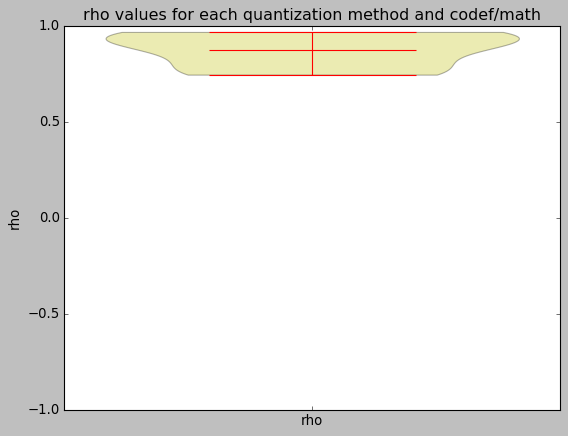

In [19]:
#violin plots with rho values
fig,ax = plt.subplots()
ax.violinplot(rho,showmeans=True)
plt.xticks([1],['rho'])
plt.ylim(-1,1)
plt.ylabel('rho')
plt.title('rho values for each quantization method and codef/math')
plt.savefig('rho_values.svg')

### Ground truth dendrograms
(has to be run with completion models cf first cell)

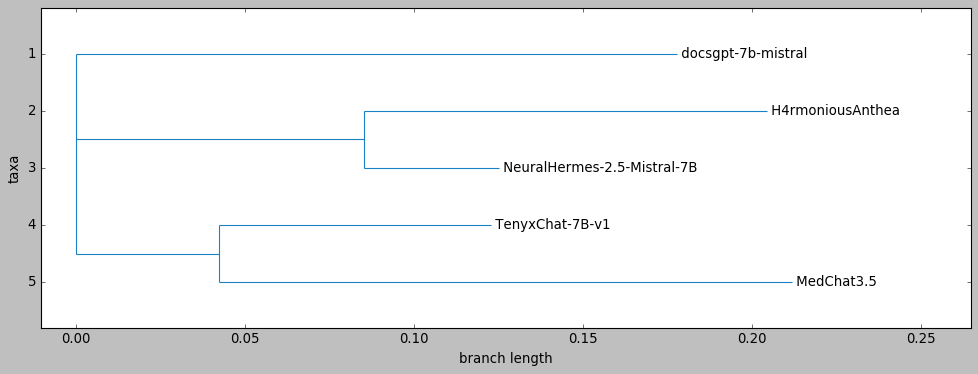

In [20]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator, _DistanceMatrix

#Setup Bio.Phylo
calculator = DistanceCalculator('identity')
constructor = DistanceTreeConstructor(calculator, 'nj')

#Prepare the models to include in the tree
model_names = [m.engine for m in models]
kept_models = ['H4rmoniousAnthea',
               'NeuralHermes-2.5-Mistral-7B',
               'MedChat3.5',
               'TenyxChat-7B-v1',
               'docsgpt-7b-mistral'
               ]
indexs = [model_names.index(kept_models[i]) for i in range(len(kept_models))]

#Prepare the distance matrix
dist_matrix = -np.log(np.maximum(nei_sim,1e-10))
kept_dist_matrix = dist_matrix[indexs][:,indexs]

#Prepare the data for Bio.Phylo
low_triangle_kl_mean = [[kept_dist_matrix[i][j] for j in range(i+1)] for i in range(len(kept_dist_matrix))]
df = _DistanceMatrix(names=[m for m in kept_models],matrix=low_triangle_kl_mean)

#build the tree
NJTree = constructor.nj(df)
NJTree.ladderize(reverse=False)

#Color the tree
prepare_tree(NJTree,kept_models,origins)

#Prepare figure
plt.figure(figsize=(15,5))
axes = plt.gca()
Phylo.draw(NJTree,axes=axes,do_show=False) #Draw rooted tree
#Phylo.draw_graphviz(NJTree,axes=axes,do_show=False) #Draw unrooted tree

#save svg
plt.savefig('dendrogram_'+str(genome_name)+'.svg')
